In [ ]:
! pip install biosignalsnotebooks

In [ ]:
pip install wfdb

In [ ]:
#download the NSRDB dataset
! wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/

In [ ]:
# Downloading the MIT-BIH dataset
# fs = 360
# Containing Anomaly
# Should get all possible EKMs
! wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

In [ ]:
!pip install bokeh==2.3.3

In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import biosignalsnotebooks as bsnb
import wfdb
from scipy.signal import detrend
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! mkdir EKM_dataset_NSRDB
! mkdir EKM_dataset_NSRDB/train
! mkdir EKM_dataset_NSRDB/test

In [ ]:
! mkdir EKM_dataset_MIT
! mkdir EKM_dataset_MIT/train
! mkdir EKM_dataset_MIT/test

In [ ]:
import os
from datetime import datetime
from PIL import Image
import numpy as np

In [ ]:
# METHODS AND UTILITITES

# How the EKM is built
def electrocardiomatrix(distance, r_peaks, filtered_ecg, init_window, peaks_window):
    init_seg = int(0.2 * distance)
    fin_seg = int(1.5 * distance)
    all_segments = []
    for peak in r_peaks[init_window:init_window + peaks_window]:
        if peak - init_seg < 0:
            segment = filtered_ecg[0:peak + fin_seg]
        else:
            segment = filtered_ecg[peak - init_seg:peak + fin_seg]
        all_segments.append(segment[:,np.newaxis])
    if all_segments[0].shape[0] < all_segments[1].shape[0]:
        zeros = np.zeros(int(all_segments[1].shape[0])-int(all_segments[0].shape[0]))[:, np.newaxis]
        new_segment = np.concatenate((zeros, all_segments[0]))
        all_segments[0] = new_segment
    try:
      ecm = np.concatenate(all_segments, 1)
    except ValueError:
      return None
    return ecm.T

# Normalizing method
def normalize(signal):
    a, b = -1, 1
    c = b - a
    aux = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    norm_ecg = c * aux + a
    return norm_ecg

# Filtering the EKG signal and obtaining its R-peaks with biosignalsnotebook
def process_ecg(unfiltered_ecg, fs):
    # Step 1 of Pan-Tompkins Algorithm - ECG Filtering (Bandpass between 5 and 15 Hz)
    filtered_signal = bsnb.detect._ecg_band_pass_filter(unfiltered_ecg, fs)
    # Step 2 of Pan-Tompkins Algorithm - ECG Differentiation
    differentiated_signal = np.diff(filtered_signal)
    # Step 3 of Pan-Tompkins Algorithm - ECG Rectification
    squared_signal = differentiated_signal * differentiated_signal
    # Step 4 of Pan-Tompkins Algorithm - ECG Integration ( Moving window integration )
    nbr_sampls_int_wind = int(0.080 * fs)
    integrated_signal = np.zeros_like(squared_signal)
    cumulative_sum = squared_signal.cumsum()
    integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[
                                                                                      :-nbr_sampls_int_wind]) / nbr_sampls_int_wind
    integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / np.arange(1, nbr_sampls_int_wind + 1)
    # Initialisation of the R peak detection algorithm
    rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, fs)
    # Detection of possible and probable R peaks
    probable_peaks, possible_peaks = bsnb.detect._detects_peaks(integrated_signal, fs)
    # Identification of definitive R peaks
    definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, fs, rr_buffer, signal_peak_1,
                                            noise_peak_1, threshold)
    # Conversion to integer type.
    definitive_peaks = np.array(list(map(int, definitive_peaks)))
    # Correcting step
    map_integers = definitive_peaks - 40 * (fs / 1000)
    definitive_peaks_reph = np.array(list(map(int, map_integers)))
    return definitive_peaks_reph, filtered_signal

# Calculates the mean distance between all peaks for each user
def peak_distance(r_peaks):
    dist = []
    for i in range(len(r_peaks)):
        if r_peaks[i] == r_peaks[-1]:
            break
        distance = r_peaks[i + 1] - r_peaks[i]
        if i == 0:
            dist.append(distance)
            continue
        if distance > np.mean(dist) + np.std(dist) * 2:
            continue
        else:
            dist.append(distance)
    return np.mean(dist)

def save_ecm(dataset_name, norm_ecm, train_filled, test_filled, train_ecms, test_ecms, path_test, path_train, train_split_percent, key, i, f, j):
    # splitting the test and train EKMs and saving them in path
    # format of {path_test}/_NumberOfRbfsInAEKM_bpf-ekm-test/train-{key=user id}-{i=serial Number}
    rand = np.random.uniform(0, 1)
    if rand <= (1 - train_split_percent) or train_filled:
        plt.savefig(f"{path_test}/5bpf-ekm-{dataset_name}-test-{key}-{str(i)}",bbox_inches='tight', pad_inches=0)
        j += 1
        if j > test_ecms:
            test_filled = True

    elif rand > (1 - train_split_percent) or test_filled:
        plt.savefig(f"{path_train}/5bpf-ekm-{dataset_name}-train-{key}-{str(i)}",bbox_inches='tight', pad_inches=0)
        f += 1
        if f >= train_ecms:
            train_filled = True

    return j,f

In [ ]:
# Getting the users ECG signals files (.dat files)
# Up to the dataset we want to use, uncomment the
# relative path of the dataset

ecg_mine_path = "/content/physionet.org/files/nsrdb/1.0.0"
# ecg_mine_path = "/content/physionet.org/files/mitdb/1.0.0"
# ecg_mine_path = "/content/ptbdb_dat_files"

files_list = os.listdir(ecg_mine_path)
users_ecg_file = []

for f in files_list:
  f_extention = f.split(".")[-1]
  if f_extention == "dat":
    users_ecg_file.append(f)

In [ ]:
# Should be 18 for NSRDB
len(users_ecg_file)

18

In [ ]:
def distance_calculaor(filtered_ecg, peaks):
  detrend_signal = detrend(filtered_ecg)
  print('\t DETREND applied')
  norm_ecg = normalize(detrend_signal)
  print('\t NORMALIZATION applied')
  # The distance calculation, may take a while
  distance = peak_distance(peaks)
  print('\t Distance calculated')

  return norm_ecg, distance

In [ ]:
def dataset_ecg_dict(usr_ecg_file, fs):
  # Getting peaks of ecg signal of user
  print(". Getting peaks of ecg signal of user")
  dat_file = f"{ecg_mine_path}/{usr_ecg_file}"
  ddbb_record = dat_file.replace(".dat", "")
  sig, fields = wfdb.rdsamp(ddbb_record)
  unfiltered_ecg = sig[:, 0]
  peaks, filtered_ecg = process_ecg(unfiltered_ecg, fs)

  # Number of peaks to be taken (from 0 to 6)
  # key is user id
  print(". Calculating distance")
  norm_ecg, distance = distance_calculaor(filtered_ecg, peaks)

  return norm_ecg, distance, peaks

In [ ]:
def dataset_extractor(dataset_name, usr_ecg_file_name, usr_ecg_dict_info, total_ecms):
  key = usr_ecg_file_name.split(".")[0]
  data_obtained = []
  distances = []
  negative = True
  j, f, i, init_window = 0, 0, 0, 0
  train_split_percent = 0.8
  test_ecms = int((1 - train_split_percent) * total_ecms)
  train_ecms = total_ecms - test_ecms
  train_filled, test_filled = False, False

  # [norm_ecg, distance, peaks]
  peaks = usr_ecg_dict_info[2]
  distance = usr_ecg_dict_info[1]
  norm_ecg = usr_ecg_dict_info[0]

  fig_width_px = 33
  fig_height_px = 21

  print(". Getting EKMs")
  while((j+f)<total_ecms):
    if (init_window >= len(peaks)) or (init_window >= len(peaks)-1): break
    ecm = electrocardiomatrix(distance, peaks, norm_ecg, init_window, peaks_window)
    if ecm is None: break
    distance = int(distance)
    norm_ecm = normalize(ecm)

    fig = plt.figure(num=1, clear=True, figsize=(fig_width_px / 80, fig_height_px / 80))
    ax = fig.add_subplot()
    ax.axis('off')

    sns.heatmap(norm_ecm, xticklabels=False, yticklabels=False, cbar=False)
    # plt.tight_layout()

    # todo: we don't really use norm_ecm parameter in save_ecm function so why we are sending it?
    j, f = save_ecm(dataset_name, norm_ecm, train_filled, test_filled, train_ecms, test_ecms, test_path, train_path, train_split_percent, key, i, f, j)
    init_window += bpf
    i += 1
    # break

In [ ]:
def pretier_print(pos, userNumber, usr_ecg_file_name):
  if pos == "begin":
    [print("-", end="") for i in range(30)]
    print("")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print(f"-> User No.{userNumber}")
    print("")
    print(usr_ecg_file_name)

  if pos == "end":
    print("")
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print("")

In [ ]:
def variable_to_file_to_drive_save(variable, saved_file_name):
  # To save a variable into text file then transfer it into drive

  # Define the source file path and destination path
  source_file_path = saved_file_name
  destination_directory = '/content/drive/MyDrive/ECG'

  # Writing the variable into a file
  import pickle

  f = open(saved_file_name, 'wb')
  pickle.dump(variable, f)

  import shutil

  # Move the file to Google Drive
  shutil.move(source_file_path, destination_directory)

In [ ]:
def loading_drive_saved_obj_to_variable(destination_path):
  # Loaing an object(variable) being saved into a file (.txt), into a variable
  import pickle

  # Open the file in binary read mode
  with open(destination_path, 'rb') as fi:
      loaded_dict = pickle.load(fi)

  print(loaded_dict)

  return loaded_dict

In [ ]:
train_path = f'EKM_dataset_NSRDB/train'
test_path = f'EKM_dataset_NSRDB/test'
bpf = 5
peaks_window = bpf-1

In [ ]:
# Creating dict of ECG signal of users for NSRDB
ecg_dict = {}
fs = 128

for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)

  norm_ecg, distance, peaks = dataset_ecg_dict(usr_ecg_file, fs)
  ecg_dict[usr_ecg_file] = [norm_ecg, distance, peaks]

  pretier_print("end", index, usr_ecg_file)

------------------------------
2023-08-12 07:43:14
-> User No.0

16420.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 07:53:37

------------------------------
2023-08-12 07:53:37
-> User No.1

17052.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 08:00:36

------------------------------
2023-08-12 08:00:36
-> User No.2

19090.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 08:05:49

------------------------------
2023-08-12 08:05:49
-> User No.3

16265.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 08:14:41

------------------------------
2023-08-12 08:14:41
-> User No.4

19088.dat
. Getting peaks of ecg signal of user

In [ ]:
import os
import pickle

# Name of the ecg file
saved_ecg_dict_file_name = 'ecg_dict_NSRDB_ECG.txt'

# Define the destination directory path
destination_directory = '/content/drive/MyDrive/ECG'

# Full file path
file_path = os.path.join(destination_directory, saved_ecg_dict_file_name)

# Saving the ecg dict
with open(file_path, 'wb') as f:
    pickle.dump(ecg_dict, f)


In [ ]:
# for NSRBD
total_ecms = 3000

In [ ]:
import pickle

# Open the file in binary read mode
with open(f"{destination_directory}/{saved_ecg_dict_file_name}", 'rb') as fi:
    loaded_dict = pickle.load(fi)

print(loaded_dict)

In [ ]:
! ls -ltrh

------------------------------
2023-08-12 10:18:25
-> User No.0

16420.dat
. Getting EKMs

2023-08-12 10:21:51

------------------------------
2023-08-12 10:21:51
-> User No.1

17052.dat
. Getting EKMs

2023-08-12 10:25:20

------------------------------
2023-08-12 10:25:20
-> User No.2

19090.dat
. Getting EKMs

2023-08-12 10:28:42

------------------------------
2023-08-12 10:28:42
-> User No.3

16265.dat
. Getting EKMs

2023-08-12 10:32:04

------------------------------
2023-08-12 10:32:04
-> User No.4

19088.dat
. Getting EKMs

2023-08-12 10:35:24

------------------------------
2023-08-12 10:35:24
-> User No.5

16273.dat
. Getting EKMs

2023-08-12 10:38:47

------------------------------
2023-08-12 10:38:47
-> User No.6

16272.dat
. Getting EKMs

2023-08-12 10:42:09

------------------------------
2023-08-12 10:42:09
-> User No.7

19830.dat
. Getting EKMs

2023-08-12 10:45:30

------------------------------
2023-08-12 10:45:30
-> User No.8

19093.dat
. Getting EKMs

2023-08-12 10

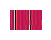

In [ ]:
# Creating dataset of EKMs [NSRDB]
import gc

ecg_dict = loaded_dict
users_ecg_file = list(loaded_dict.keys())

for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)
  dataset_extractor('NSRDB' ,usr_ecg_file, ecg_dict[usr_ecg_file], total_ecms)
  pretier_print("end", index, usr_ecg_file)
  gc.collect()
  # break

In [ ]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

def format_size(size):
    # Convert bytes to human-readable format
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.2f} {unit}"
        size /= 1024.0

if __name__ == "__main__":
    folder_path = "/content/EKM_dataset_NSRDB"  # Replace with the actual folder path
    total_size = get_folder_size(folder_path)
    formatted_size = format_size(total_size)
    print(f"Total size of {folder_path}: {formatted_size}")



In [ ]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

def format_size(size):
    # Convert bytes to human-readable format
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.2f} {unit}"
        size /= 1024.0

if __name__ == "__main__":
    folder_path = "/content/EKM_dataset_MIT"  # Replace with the actual folder path
    total_size = get_folder_size(folder_path)
    formatted_size = format_size(total_size)
    print(f"Total size of {folder_path}: {formatted_size}")



Total size of /content/EKM_dataset_MIT: 0.00 B


In [ ]:
import os
import shutil

def move_contents(source_folder, destination_folder):
    try:
        # Create the destination folder if it doesn't exist
        if not os.path.exists(destination_folder):
            os.makedirs(destination_folder)

        # Iterate through each item in the source folder
        for item in os.listdir(source_folder):
            source_item_path = os.path.join(source_folder, item)
            destination_item_path = os.path.join(destination_folder, item)

            # Move the item to the destination folder
            shutil.move(source_item_path, destination_item_path)

        print("Contents moved successfully!")
    except Exception as e:
        print("An error occurred:", str(e))

# Replace these paths with your actual source and destination folder paths
source_folder_path = "/content/EKM_dataset_NSRDB"
destination_folder_path = "/content/drive/MyDrive/EKM_dataset_NSRDB"

move_contents(source_folder_path, destination_folder_path)



Contents moved successfully!


In [ ]:
#19 m

In [ ]:
import os

def get_folder_size(folder_path):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            total_size += os.path.getsize(file_path)
    return total_size

def format_size(size):
    # Convert bytes to human-readable format
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.2f} {unit}"
        size /= 1024.0

if __name__ == "__main__":
    folder_path = "/content/drive/MyDrive/EKM_dataset_NSRDB"  # Replace with the actual folder path
    total_size = get_folder_size(folder_path)
    formatted_size = format_size(total_size)
    print(f"Total size of {folder_path}: {formatted_size}")



Total size of /content/drive/MyDrive/EKM_dataset_NSRDB: 25.98 MB


In [ ]:
# Getting the users ECG signals files (.dat files)
ecg_mine_path = "/content/physionet.org/files/mitdb/1.0.0"

files_list = os.listdir(ecg_mine_path)
users_ecg_file = []

for f in files_list:
  f_extention = f.split(".")[-1]
  if f_extention == "dat":
    users_ecg_file.append(f)


In [ ]:
# Should be 48 for MIT-BIHDB
len(users_ecg_file)

48

In [ ]:
train_path = f'EKM_dataset_MIT/train'
test_path = f'EKM_dataset_MIT/test'
bpf = 5
peaks_window = bpf-1

In [ ]:
# Creating dict of ECG signal of users for MIT-BIH dataset
ecg_dict = {}
fs = 360
for index, usr_ecg_file in enumerate(users_ecg_file):
  pretier_print("begin", index, usr_ecg_file)

  norm_ecg, distance, peaks = dataset_ecg_dict(usr_ecg_file, fs)
  ecg_dict[usr_ecg_file] = [norm_ecg, distance, peaks]

  pretier_print("end", index, usr_ecg_file)

------------------------------
2023-08-12 12:24:17
-> User No.0

123.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 12:24:18

------------------------------
2023-08-12 12:24:18
-> User No.1

209.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 12:24:20

------------------------------
2023-08-12 12:24:20
-> User No.2

201.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 12:24:20

------------------------------
2023-08-12 12:24:20
-> User No.3

111.dat
. Getting peaks of ecg signal of user
. Calculating distance
	 DETREND applied
	 NORMALIZATION applied
	 Distance calculated

2023-08-12 12:24:21

------------------------------
2023-08-12 12:24:21
-> User No.4

205.dat
. Getting peaks of ecg signal of user
. Calcula

In [ ]:
#47 s

In [ ]:
import os
import pickle

# Name of the ecg file
saved_ecg_dict_file_name = 'ecg_dict_MIT_ECG.txt'

# Define the destination directory path
destination_directory = '/content/drive/MyDrive/ECG'

# Full file path
file_path = os.path.join(destination_directory, saved_ecg_dict_file_name)

# Saving the ecg dict
with open(file_path, 'wb') as f:
    pickle.dump(ecg_dict, f)


In [ ]:
import pickle

# Open the file in binary read mode
with open(f"{destination_directory}/{saved_ecg_dict_file_name}", 'rb') as fi:
    loaded_dict = pickle.load(fi)

print(loaded_dict)

{'123.dat': [array([-0.17907935, -0.16199665, -0.14527343, ..., -0.18814297,
       -0.18352214, -0.17892341]), 427.35574983187627, array([    61,    541,   1012, ..., 648988, 649333, 649680])], '209.dat': [array([-0.04150095, -0.05180243, -0.06173643, ..., -0.12975588,
       -0.08622002, -0.04044836]), 215.64100840336135, array([   180,    416,    650, ..., 649378, 649618, 649848])], '201.dat': [array([-0.21971472, -0.22726125, -0.23437817, ..., -0.29717054,
       -0.25852296, -0.21802599]), 226.26393629124004, array([   151,    406,    678, ..., 648411, 649096, 649791])], '111.dat': [array([0.07858308, 0.08489793, 0.09092983, ..., 0.09167248, 0.08566631,
       0.07845153]), 303.7977099236641, array([   188,    482,    796, ..., 649155, 649447, 649730])], '205.dat': [array([ 0.05686121,  0.05720733,  0.05746906, ..., -0.0734716 ,
       -0.00908903,  0.05834184]), 243.66653741760373, array([   221,    458,    698, ..., 649318, 649588, 649849])], '116.dat': [array([-0.07101339, -0.0

In [ ]:
ecg_dict.keys()


dict_keys(['123.dat', '209.dat', '201.dat', '111.dat', '205.dat', '116.dat', '234.dat', '210.dat', '219.dat', '119.dat', '230.dat', '232.dat', '213.dat', '107.dat', '217.dat', '102.dat', '101.dat', '207.dat', '215.dat', '112.dat', '108.dat', '124.dat', '214.dat', '200.dat', '208.dat', '203.dat', '100.dat', '233.dat', '231.dat', '105.dat', '109.dat', '117.dat', '212.dat', '228.dat', '220.dat', '114.dat', '221.dat', '202.dat', '121.dat', '118.dat', '122.dat', '115.dat', '103.dat', '104.dat', '223.dat', '222.dat', '106.dat', '113.dat'])

------------------------------
2023-08-12 12:32:53
-> User No.0

123.dat
. Getting EKMs

2023-08-12 12:33:17

------------------------------
2023-08-12 12:33:17
-> User No.1

209.dat
. Getting EKMs

2023-08-12 12:33:59

------------------------------
2023-08-12 12:33:59
-> User No.2

201.dat
. Getting EKMs

2023-08-12 12:34:24

------------------------------
2023-08-12 12:34:25
-> User No.3

111.dat
. Getting EKMs

2023-08-12 12:34:57

------------------------------
2023-08-12 12:34:57
-> User No.4

205.dat
. Getting EKMs

2023-08-12 12:35:33

------------------------------
2023-08-12 12:35:33
-> User No.5

116.dat
. Getting EKMs

2023-08-12 12:36:06

------------------------------
2023-08-12 12:36:06
-> User No.6

234.dat
. Getting EKMs

2023-08-12 12:36:45

------------------------------
2023-08-12 12:36:45
-> User No.7

210.dat
. Getting EKMs

2023-08-12 12:37:20

------------------------------
2023-08-12 12:37:21
-> User No.8

219.dat
. Getting EKMs

2023-08-12 12:37:52

----------

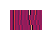

In [ ]:
  # Creating dataset of EKMs [MIT-BIHDB]
import gc

users_ecg_file = list(ecg_dict.keys())

for index, usr_ecg_file in enumerate(users_ecg_file):
   pretier_print("begin", index, usr_ecg_file)
   total_ecms = len(ecg_dict[usr_ecg_file][2])
   dataset_extractor("MITDB", usr_ecg_file, ecg_dict[usr_ecg_file], total_ecms)
   pretier_print("end", index, usr_ecg_file)
   gc.collect()
  # break